In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
# sources
# example - https://medium.com/@chrisfotache/text-classification-in-python-pipelines-nlp-nltk-tf-idf-xgboost-and-more-b83451a327e0
# https://github.com/ameasure/autocoding-class/blob/master/machine_learning.ipynb

In [3]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

C:\Users\Public\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Public\Anaconda\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Import the data

In [4]:
# read the csv file into a DataFrame
df = pd.read_csv(r'Health_Care_Ticket.csv', encoding='iso-8859-1')
#supplemental = pd.read_csv(r'jobboard_reed_uk_secondary.csv')

df = df.dropna()
df = df.iloc[0:10000,:]
df.head()

,fileid,SUMMARY,DATA,categories,sub_categories,previous_appointment,ID
0,2015561331001,Pt aware that he needs ROV for refill,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,PRESCRIPTION,REFILL,No,2015_5_6133_1001
1,2015561341001,Mom wants to know if the Focalin needs some do...,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,ASK_A_DOCTOR,MEDICATION RELATED,No,2015_5_6134_1001
2,2015561351001,pt called to discuss nortryptiline. she says s...,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,ASK_A_DOCTOR,MEDICATION RELATED,No,2015_5_6135_1001
3,2015561361001,FYI Nortryptline medication.,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,MISCELLANEOUS,OTHERS,No,2015_5_6136_1001
4,2015561371001,Letter of patient establishment request,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,MISCELLANEOUS,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)",No,2015_5_6137_1001


## Train, valid, test splits

In [5]:
# first lets stratify the train (+valid) and test data, such that the test data is reflective of the classes we might see
from sklearn.model_selection import train_test_split

train_valid, test = train_test_split(df, test_size=0.2, stratify=df["sub_categories"], random_state=42) 
train, valid = train_test_split(train_valid, test_size=0.25, stratify=train_valid["sub_categories"], random_state=42) 

#train_valid, test = train_test_split(df, test_size=0.2, random_state=42) 
#train, valid = train_test_split(train_valid, test_size=0.25, random_state=42) 

print("training dataset: ", train.shape[0])
print("validation dataset: ", valid.shape[0])
print("testing dataset: ", test.shape[0])
#print("supplemental dataset: ", supplemental.shape[0])

# display class sizes of train_valid split
df_group = train_valid.groupby(['sub_categories']).size().reset_index(name='labels').sort_values(by=['labels'], ascending=False)
df_group.head()

training dataset:  6000
validation dataset:  2000
testing dataset:  2000


,sub_categories,labels
15,REFILL,1612
7,MEDICATION RELATED,1449
8,NEW APPOINTMENT,1325
9,OTHERS,633
18,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)",562


In [6]:
df_train = train.copy()
#df_train = train.iloc[0:1000,:]
df_test = test.copy()
df_valid = valid.copy()

# rename classes and labels
df_train = df_train.rename(columns={'SUMMARY': 'text', 'sub_categories':'code'})
df_test = df_test.rename(columns={'SUMMARY': 'text', 'sub_categories':'code'})
df_valid = df_valid.rename(columns={'SUMMARY': 'text', 'sub_categories':'code'})

print(df_train.shape[0])

6000


### Custom Analysis Function

In [7]:
# based on the error rate we want to predict at we find what our autocoding rate will be lowered to
def threshold_byerror(error_tolerance, code, pred, prob):
    df = pd.DataFrame({'code': code, 'pred': pred, 'prob': prob})
    
    # create a threshold report
    range = np.arange(0.5, 1.0, 0.01).tolist()
    range.sort(reverse=True)
    df_scores = pd.DataFrame(range, columns=['confidence'])

    # find the threshold 
    def threshold_error(data, pred, prob, value):
        df_temp = data[data[prob] > value]
        accuracy = round(accuracy_score(df_temp['code'], df_temp[pred]) * 100, 2)
        error_rate = 100 - accuracy
        return error_rate

    def threshold_percent(data, prob, value):
        count_overall = data.shape[0]
        df_temp = data[data[prob] > value]
        count_threshold = df_temp.shape[0]
        percent = round((count_threshold / count_overall) * 100, 2)
        return percent
    
    df_scores['error'] =  df_scores.apply(lambda row: threshold_error(df, 'pred', 'prob', row['confidence']), axis=1)
    df_scores['rate'] =  df_scores.apply(lambda row: threshold_percent(df, 'prob', row['confidence']), axis=1)
    df_scores = df_scores.replace(np.nan,0)
    
    df_selected = df_scores.iloc[(df_scores['error'] - error_tolerance).abs().argsort()[:2]]
    threshold_selected = round(df_selected.confidence.iloc[0]*100,2)
    error_selected = round(df_selected.error.iloc[0],2)
    rate_selected = round(df_selected.rate.iloc[0],2)
    #text = ("Threshold: " + str(threshold_selected) +
    #       "%. Error: " + str(error_selected) + "%. Autocoding: " + str(rate_selected) + "%.")
    return threshold_selected, error_selected, rate_selected

## Text Preprocessing, Vectorizer, Model Features

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


In [9]:
# source: https://stackoverflow.com/questions/37473219/how-to-remove-dates-from-a-list-in-python
# source: https://stackoverflow.com/questions/26294245/python-regex-find-all-matches-in-string-and-replace
import re

def replace_date(text):
    # order matters
    if re.search(r'[0-9]{2}[\/,:][0-9]{2}[\/,:][0-9]{2,4}', text, re.IGNORECASE):
        r = re.compile(r'[0-9]{2}[\/,:][0-9]{2}[\/,:][0-9]{2,4}', re.IGNORECASE)
        text = r.sub(r'date', text)
    if re.search(r'[0-9]{1,2}[\/,:][0-9]{2,4}', text, re.IGNORECASE):
        r = re.compile(r'[0-9]{1,2}[\/,:][0-9]{2,4}', re.IGNORECASE)
        text = r.sub(r'date', text)
    if re.search(r'[0-9]{4}', text, re.IGNORECASE):
        r = re.compile(r'[0-9]{4}', re.IGNORECASE)
        text = r.sub(r'date', text)
    
    return text

string = "11/23 2019 12/12/21 @ 10:45 9:10 is a date"
print(string)
print(replace_date(string))


11/23 2019 12/12/21 @ 10:45 9:10 is a date
date date date @ date date is a date


In [10]:
# source: https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-3/

from sklearn.preprocessing import FunctionTransformer

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})


In [11]:
# function for text cleaning 
import re

def clean_text(text): 
    text = re.sub("\'", "", text)           # remove backslash-apostrophe
    text = re.sub("[^a-zA-Z]"," ",text)     # remove everything except alphabets 
    text = ' '.join(text.split())           # remove whitespaces 
    text = text.lower()                     # convert text to lowercase 
    return text

In [12]:
# vectorizer
vect = CountVectorizer(strip_accents = ascii,
                       lowercase = False,
                       ngram_range = (1,2),
                       analyzer = 'char',
                       binary=True) # one-hot encoding (true)


# resource: https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html

# https://stackoverflow.com/questions/36253258/how-to-fit-different-inputs-into-an-sklearn-pipeline
# TfidfTransformer and POSTransformer


In [13]:
# weight vectors using tf-idf
#tfidf = TfidfTransformer()

tfidf = TfidfTransformer(sublinear_tf=True, use_idf=True)

# sublinear_tf=True, use_idf=True used for PCA

In [14]:
# XGBoost model
xgb = XGBClassifier(
                    eta = 0.75, # learning rate
                    nthread = -1,
                    seed = 42,
                    
                    # values to tune
                    max_depth=7, # higher depth allow model to learn relations very specific to a particular sample (3-10)
                    gamma = 1, # specifies the minimum loss reduction required to make a split
                    scale_pos_weight = 1, # >0 should be used in case of high class imbalance as it helps in faster convergence.
                    subsample = 0.75, # (0.5-1) lower to help overfitting, fraction of obs randomly samples for each tree
                    min_child_weight=1, # higher value helps overfitting (min “number of observations”)
                    
                    # overfitting adjustment
                    alpha=0, # L1 regularization term on weight
                    lamda=1 # L2 regularization term on weights
                    
                    ) # set to use all

# resource: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [15]:
from sklearn.decomposition import PCA, TruncatedSVD

pca = TruncatedSVD(n_components=100, random_state=42)

# https://scikit-learn.org/stable/modules/decomposition.html#decompositions
# LSA is known to combat the effects of synonymy and polysemy (both of which roughly mean there are multiple meanings per word)
# to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data

# examples of Truncated SVD
corpus = ['This is the first document.',
         'This document is the second document.',
         'And this is the third one.',
          'Is this the first document?',]

pipe = Pipeline([('count', CountVectorizer()),
                 ('tfid', TfidfTransformer()),
                 ('pca', TruncatedSVD(n_components=3, random_state=42))]).fit(corpus)

print("count",pipe['count'].transform(corpus).toarray())
print("tfidf",pipe['tfid'].idf_)
print("pca values: 3",pipe['pca'].singular_values_)



count [[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
tfidf [1.91629073 1.22314355 1.51082562 1.         1.91629073 1.91629073
 1.         1.91629073 1.        ]
pca values: 3 [1.63851261 0.92722441 0.6749306 ]


In [16]:
# XGBoost model
xgb = XGBClassifier(
                    eta = 0.2, # learning rate
                    nthread = -1,
                    seed = 42,
                    
                    # values to tune
                    max_depth=7, # higher depth allow model to learn relations very specific to a particular sample (3-10)
                    gamma = 3, # specifies the minimum loss reduction required to make a split
                    scale_pos_weight = 1, # >0 should be used in case of high class imbalance as it helps in faster convergence.
                    subsample = 0.75, # (0.5-1) lower to help overfitting, fraction of obs randomly samples for each tree
                    min_child_weight=1, # higher value helps overfitting (min “number of observations”)
                    
                    # overfitting adjustment
                    alpha=0, # L1 regularization term on weight
                    lamda=1 # L2 regularization term on weights
                    
                    ) # set to use all

# resource: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

## Pipeline steps

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [34]:
# switch train datasets for testing
df_train = train.copy()
#df_train = train.iloc[0:2000,:]
df_train = df_train.rename(columns={'SUMMARY': 'text', 'sub_categories':'code'})

In [35]:
text_clf = Pipeline(steps=[('replace_date',pipelinize(replace_date)),
                            ('clean',pipelinize(clean_text)),
                            ('vect', vect),
                            ('tfidf', tfidf),
                            ('clf', xgb)
                          ])

In [36]:
model = text_clf.fit(df_train.text, df_train.code) # create the model

In [37]:
y_train = df_train.code
y_train_pred = model.predict(df_train.text)
y_train_prob = model.predict_proba(df_train.text) # gives an array of all class probabilities
y_train_prob_max = y_train_prob.max(axis=1) # find the highest prob, associated with clf.predict()

y_valid = df_valid.code
y_valid_pred = model.predict(df_valid.text)
y_valid_prob = model.predict_proba(df_valid.text) # gives an array of all class probabilities
y_valid_prob_max = y_valid_prob.max(axis=1) # find the highest prob, associated with clf.predict()

y_test = df_test.code
y_test_pred = model.predict(df_test.text)
y_test_prob = model.predict_proba(df_test.text) # gives an array of all class probabilities
y_test_prob_max = y_test_prob.max(axis=1) # find the highest prob, associated with clf.predict()

# metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_w_f1 = f1_score(y_train, y_train_pred, average = "weighted")
train_w_precision = precision_score(y_train, y_train_pred, average = "weighted")
train_w_recall = recall_score(y_train, y_train_pred, average = "weighted") 
train_threshold, train_error, train_rate = threshold_byerror(10,y_train,y_train_pred,y_train_prob_max)

valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_w_f1 = f1_score(y_valid, y_valid_pred, average = "weighted")
valid_w_precision = precision_score(y_valid, y_valid_pred, average = "weighted")
valid_w_recall = recall_score(y_valid, y_valid_pred, average = "weighted")    
valid_threshold, valid_error, valid_rate = threshold_byerror(10,y_valid,y_valid_pred,y_valid_prob_max)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_w_f1 = f1_score(y_test, y_test_pred, average = "weighted")
test_w_precision = precision_score(y_test, y_test_pred, average = "weighted")
test_w_recall = recall_score(y_test, y_test_pred, average = "weighted")    
test_threshold, test_error, test_rate = threshold_byerror(10,y_test,y_test_pred,y_test_prob_max)

# create a dataframe from the logged lists
df_train_valid_test_results = pd.DataFrame(
    {'dataset': ['train','valid','test'],
     'accuracy': [train_accuracy, valid_accuracy, test_accuracy],
      'weighted_f1': [train_w_f1,valid_w_f1, test_w_f1],
      'weighted_precision': [train_w_precision, valid_w_precision, test_w_precision],
      'weighted_recall': [train_w_recall, valid_w_recall, test_w_recall],
      'threshold_selected':[train_threshold,valid_threshold, test_threshold],
      'error_rate':[train_error, valid_error, test_error],
     'autocoding_rate':[train_rate, valid_rate, test_rate]
        
     })
df_train_valid_test_results.head()


C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

,dataset,accuracy,weighted_f1,weighted_precision,weighted_recall,threshold_selected,error_rate,autocoding_rate
0,train,0.835333,0.835724,0.851122,0.835333,50.0,5.12,68.95
1,valid,0.596000,0.578555,0.584282,0.596000,83.0,9.92,24.70
2,test,0.569500,0.549188,0.555195,0.569500,79.0,10.03,29.40


In [38]:
# save the predictions to a new dataframe for ensemble analysis
# save the predictions to a new dataframe for ensemble analysis
y_test_base = y_test.copy()
y_test_pred_base = y_test_pred.copy()
y_test_prob_max_base = y_test_prob_max.copy()

test_results = pd.DataFrame(
    {'code': y_test_base,
     'pred': y_test_pred_base,
      'prob': y_test_prob_max_base,
    })

test_results_threshold = test_results[test_results['prob'] > (test_threshold/100)]

# standard classification report
report = classification_report(test_results_threshold.code, test_results_threshold.pred, output_dict=True)
df_class_base = pd.DataFrame(report).transpose()
df_class_base["class"] = df_class_base.index
df_class_base = df_class_base.reset_index(drop=True)
df_class_base = df_class_base.iloc[:-3,:]
df_class_base.head()

C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

,f1-score,precision,recall,support,class
0,0.800000,1.000000,0.666667,6.0,CANCELLATION
1,0.000000,0.000000,0.000000,1.0,CHANGE OF PHARMACY
2,0.800000,0.666667,1.000000,2.0,CHANGE OF PROVIDER
3,0.833333,0.833333,0.833333,6.0,FOLLOW UP ON PREVIOUS REQUEST
4,0.916667,0.873016,0.964912,57.0,LAB RESULTS


# Feature Selection & Dimensionality Reduction

Resources
1. https://scikit-learn.org/stable/modules/feature_selection.html
2. https://towardsdatascience.com/feature-selection-and-dimensionality-reduction-f488d1a035de
3. https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
4. https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/

In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest, f_classif, SelectFdr
from sklearn import feature_selection

from xgboost import plot_importance
from matplotlib import pyplot

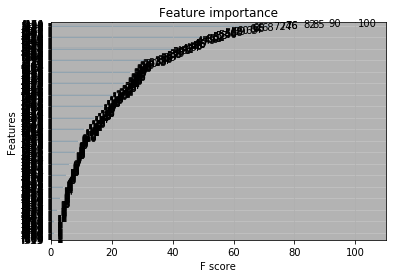

Features in model:  639


In [24]:
# plot feature importance of model before applying features selectin, dim reduction
plot_importance(model['clf'])
pyplot.show()
print("Features in model: ", len(model['clf'].feature_importances_))

Here we can see the number of features in the model and the F-scores

# HyperParameter Tuning

Hyperparameter tune model features first

### Grid-search feature selection

We want to search all combinations. Ideally we would run with model features as well but that would take too long.

In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score


In [143]:
# switch train datasets for testing
#df_train = train.copy()
df_train = train.iloc[0:2000,:]
df_train = df_train.rename(columns={'SUMMARY': 'text', 'sub_categories':'code'})

In [144]:
# options: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# custom: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
# https://stackoverflow.com/questions/23170874/passing-parameters-to-a-score-func-in-scikit-during-cross-validation

# multi-metric grid-search
scoring = {'accuracy': 'accuracy', 'weighted_f1': 'f1_weighted'}

In [145]:
text_clf = Pipeline(steps=[('replace_date',pipelinize(replace_date)),
                            ('clean',pipelinize(clean_text)),
                            ('vect', vect),
                            ('tfidf', tfidf),
                            ('feature_selection', feature),
                            ('pca', pca),
                            ('clf', xgb),
                          ])

In [146]:
# feature selection methods
from sklearn.feature_selection import SelectKBest, f_classif, SelectFdr, RFECV, SelectFpr, mutual_info_classif
 
feature_SelectKBest = feature_selection.SelectKBest(score_func=f_classif, k=10) # k highest scores
feature_SelectFpr = feature_selection.SelectFpr(score_func=f_classif, alpha=0.05) # False Positive Rate test
feature_SelectFdr = feature_selection.SelectFdr(score_func=f_classif, alpha=0.05) # estimated false discovery rate
feature_SelectFwe = feature_selection.SelectFwe(score_func=f_classif, alpha=0.05) # Family-wise error rate

# feature selection: SelectFpr, SelectFdr, SelectFwe
parameters = {
                'feature_selection':[feature_SelectFpr, feature_SelectFdr, feature_SelectFwe],
                'feature_selection__alpha':[0.1,0.05,0.01],
                #'pca':[None, pca],
                
             }
   
gs_clf = GridSearchCV(text_clf, parameters, scoring=scoring, refit=False, cv=2, n_jobs=-1, verbose=10) # verbose adds details during logging, n_jobs(-1) = in parallel
gs_clf = gs_clf.fit(df_train.text, df_train.code)
gridsearch = pd.DataFrame(gs_clf.cv_results_)

# feature selection: SelectKbest
parameters = {              
                'feature_selection':[feature_SelectKBest],
                'feature_selection__score_func':[f_classif,mutual_info_classif],
                #'pca':[None, pca]
             }

gs_clf_2 = GridSearchCV(text_clf, parameters, scoring=scoring, refit=False, cv=2, n_jobs=-1, verbose=10) # verbose adds details during logging, n_jobs(-1) = in parallel
gs_clf_2 = gs_clf_2.fit(df_train.text, df_train.code)
gridsearch_2 = pd.DataFrame(gs_clf_2.cv_results_)

# merge results from both gridsearches
gridsearch = gridsearch.append(gridsearch_2)
gridsearch = gridsearch.sort_values(by=['mean_test_weighted_f1'], ascending=False)
gridsearch.head(10)


Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:   40.6s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:   41.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:  1.3min remaining:   48.8s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  1.3min remaining:   30.0s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  1.3min remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0788s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished
C:\Users\Public\Anaconda\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_weighted_f1,param_feature_selection,param_feature_selection__alpha,param_feature_selection__score_func,params,rank_test_accuracy,rank_test_weighted_f1,split0_test_accuracy,split0_test_weighted_f1,split1_test_accuracy,split1_test_weighted_f1,std_fit_time,std_score_time,std_test_accuracy,std_test_weighted_f1
6,36.000313,0.371615,0.5020,0.469251,"SelectFwe(alpha=0.05, score_func=<function f_c...",0.1,NaN,"{'feature_selection': SelectFwe(alpha=0.05, sc...",1,1,0.510,0.478413,0.494,0.460089,0.907452,0.007566,0.0080,0.009162
7,37.898203,0.262034,0.4970,0.463989,"SelectFwe(alpha=0.05, score_func=<function f_c...",0.05,NaN,"{'feature_selection': SelectFwe(alpha=0.05, sc...",2,2,0.502,0.468556,0.492,0.459421,0.781995,0.101444,0.0050,0.004568
5,36.709659,0.264892,0.4900,0.460658,"SelectFdr(alpha=0.05, score_func=<function f_c...",0.01,NaN,"{'feature_selection': SelectFdr(alpha=0.05, sc...",3,3,0.500,0.471607,0.480,0.449710,1.583450,0.063250,0.0100,0.010949
8,23.819174,0.161568,0.4855,0.454870,"SelectFwe(alpha=0.05, score_func=<function f_c...",0.01,NaN,"{'feature_selection': SelectFwe(alpha=0.05, sc...",4,4,0.483,0.456356,0.488,0.453383,0.451862,0.002991,0.0025,0.001487
2,36.658970,0.257827,0.4855,0.449375,"SelectFpr(alpha=0.05, score_func=<function f_c...",0.01,NaN,"{'feature_selection': SelectFpr(alpha=0.05, sc...",4,5,0.487,0.451893,0.484,0.446857,1.225034,0.009475,0.0015,0.002518
1,36.645506,0.295479,0.4810,0.445926,"SelectFpr(alpha=0.05, score_func=<function f_c...",0.05,NaN,"{'feature_selection': SelectFpr(alpha=0.05, sc...",7,6,0.480,0.449224,0.482,0.442628,0.845532,0.039655,0.0010,0.003298
4,37.993005,0.364821,0.4820,0.444659,"SelectFdr(alpha=0.05, score_func=<function f_c...",0.05,NaN,"{'feature_selection': SelectFdr(alpha=0.05, sc...",6,7,0.476,0.439821,0.488,0.449498,0.211688,0.027723,0.0060,0.004839
3,36.184720,0.255580,0.4740,0.438917,"SelectFdr(alpha=0.05, score_func=<function f_c...",0.1,NaN,"{'feature_selection': SelectFdr(alpha=0.05, sc...",9,8,0.480,0.449224,0.468,0.428609,0.905373,0.004743,0.0060,0.010307
0,37.923898,0.249097,0.4765,0.437723,"SelectFpr(alpha=0.05, score_func=<function f_c...",0.1,NaN,"{'feature_selection': SelectFpr(alpha=0.05, sc...",8,9,0.485,0.451957,0.468,0.423488,0.045877,0.001251,0.0085,0.014235
0,0.068318,0.000000,NaN,NaN,"SelectKBest(k=10, score_func=<function f_class...",NaN,<function f_classif at 0x000001D9B36F86A8>,"{'feature_selection': SelectKBest(k=10, score_...",1,1,NaN,NaN,NaN,NaN,0.000499,0.000000,NaN,NaN


### Grid-Search: PCA analysis

#### Create model using highest weighted-f1 parms

In [147]:
# best parameters from feature selection
feature_SelectFwe = feature_selection.SelectFwe(score_func=f_classif, alpha=0.1) # Family-wise error rate

text_clf = Pipeline(steps=[('replace_date',pipelinize(replace_date)),
                            ('clean',pipelinize(clean_text)),
                            ('vect', vect),
                            ('tfidf', tfidf),
                            ('feature_selection', feature_SelectFwe),
                            ('pca', pca),
                            ('clf', xgb),
                          ])


In [151]:
parameters = {'pca__n_components': range(25,200,25)} # range(50,500,50) = 250 optimal

gs_clf_3 = GridSearchCV(text_clf, parameters, scoring=scoring, refit=False, cv=2, n_jobs=-1, verbose=10) # verbose adds details during logging, n_jobs(-1) = in parallel
gs_clf_3 = gs_clf_3.fit(df_train.text, df_train.code)

# results of gridsearch
gridsearch = pd.DataFrame(gs_clf_3.cv_results_)
gridsearch = gridsearch.sort_values(by=['mean_test_weighted_f1'], ascending=False)
gridsearch.head(10)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:   28.4s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:   40.9s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:   41.3s remaining:   41.3s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:   53.1s remaining:   29.5s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  1.4min remaining:   22.2s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  1.7min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_accuracy,split1_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_weighted_f1,split1_test_weighted_f1,mean_test_weighted_f1,std_test_weighted_f1,rank_test_weighted_f1
1,29.670325,1.595174,0.358570,0.018287,50,{'pca__n_components': 50},0.505,0.514,0.5095,0.0045,1,0.478356,0.481179,0.479767,0.001412,1
3,53.928518,1.229488,0.353702,0.027207,100,{'pca__n_components': 100},0.510,0.494,0.5020,0.0080,2,0.478413,0.460089,0.469251,0.009162,2
4,62.340650,0.341316,0.352399,0.039022,125,{'pca__n_components': 125},0.500,0.485,0.4925,0.0075,5,0.476681,0.451469,0.464075,0.012606,3
2,42.053082,1.517855,0.358016,0.036134,75,{'pca__n_components': 75},0.508,0.480,0.4940,0.0140,3,0.480761,0.446784,0.463773,0.016989,4
0,18.997923,0.085098,0.391000,0.030977,25,{'pca__n_components': 25},0.495,0.492,0.4935,0.0015,4,0.459572,0.463317,0.461444,0.001872,5
5,69.219458,0.194755,0.346013,0.016739,150,{'pca__n_components': 150},0.490,0.477,0.4835,0.0065,6,0.470489,0.443822,0.457155,0.013334,6
6,0.166536,0.002386,0.000000,0.000000,175,{'pca__n_components': 175},NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,7


## Final Model (Train with Entire Dataset)

In [25]:
#df_train = train.iloc[0:2000,:]
df_train = train.copy()
df_train = df_train.rename(columns={'SUMMARY': 'text', 'sub_categories':'code'})

In [26]:
feature_SelectFwe = feature_selection.SelectFwe(score_func=f_classif, alpha=0.1) # Family-wise error rate
pca = TruncatedSVD(n_components=50, random_state=42) # very slow with higher components

text_clf = Pipeline(steps=[('replace_date',pipelinize(replace_date)),
                            ('clean',pipelinize(clean_text)),
                            ('vect', vect),
                            ('tfidf', tfidf),
                            ('feature_selection', feature_SelectFwe),
                            ('pca', pca),
                            ('clf', xgb),
                          ])

model = text_clf.fit(df_train.text, df_train.code) # create the model


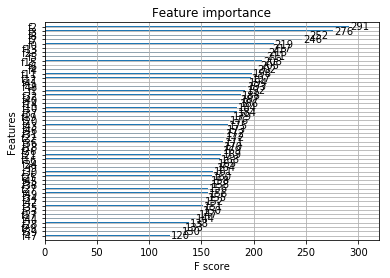

Features in model:  50


In [27]:
plot_importance(model['clf'])
pyplot.show()
print("Features in model: ", len(model['clf'].feature_importances_))

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_train = df_train.code
y_train_pred = model.predict(df_train.text)
y_train_prob = model.predict_proba(df_train.text) # gives an array of all class probabilities
y_train_prob_max = y_train_prob.max(axis=1) # find the highest prob, associated with clf.predict()

y_test = df_test.code
y_test_pred = model.predict(df_test.text)
y_test_prob = model.predict_proba(df_test.text) # gives an array of all class probabilities
y_test_prob_max = y_test_prob.max(axis=1) # find the highest prob, associated with clf.predict()


# metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_w_f1 = f1_score(y_train, y_train_pred, average = "weighted")
train_w_precision = precision_score(y_train, y_train_pred, average = "weighted")
train_w_recall = recall_score(y_train, y_train_pred, average = "weighted") 
train_threshold, train_error, train_rate = threshold_byerror(10,y_train,y_train_pred,y_train_prob_max)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_w_f1 = f1_score(y_test, y_test_pred, average = "weighted")
test_w_precision = precision_score(y_test, y_test_pred, average = "weighted")
test_w_recall = recall_score(y_test, y_test_pred, average = "weighted")    
test_threshold, test_error, test_rate = threshold_byerror(10,y_test,y_test_pred,y_test_prob_max)

# create a dataframe from the logged lists
df_train_test_results = pd.DataFrame(
    {'dataset': ['train','test'],
     'accuracy': [train_accuracy, test_accuracy],
      'weighted_f1': [train_w_f1,test_w_f1],
      'weighted_precision': [train_w_precision, test_w_precision],
      'weighted_recall': [train_w_recall, test_w_recall],
      'threshold_selected':[train_threshold,test_threshold],
      'error_rate':[train_error, test_error],
     'autocoding_rate':[train_rate, test_rate]
        
     })
df_train_test_results.head()

C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,dataset,accuracy,weighted_f1,weighted_precision,weighted_recall,threshold_selected,error_rate,autocoding_rate
0,train,0.837667,0.836810,0.851548,0.837667,50.0,4.70,66.70
1,test,0.557000,0.528402,0.535586,0.557000,80.0,10.17,26.55



Here we can see that the overall model metrics are not as good as the original model, and even reduce the autocoding rate by 3% (while holding error at 10%). The only other thing to look at is whether our classes performed better.


In [33]:
# save the predictions to a new dataframe for ensemble analysis
y_test_feature = y_test.copy()
y_test_pred_feature = y_test_pred.copy()
y_test_prob_max_feature = y_test_prob_max.copy()

test_results = pd.DataFrame(
    {'code': y_test_feature,
     'pred': y_test_pred_feature,
      'prob': y_test_prob_max_feature,
    })

test_results_threshold = test_results[test_results['prob'] > (test_threshold/100)]

# standard classification report
report = classification_report(test_results_threshold.code, test_results_threshold.pred, output_dict=True)
df_class_feature = pd.DataFrame(report).transpose()
df_class_feature["class"] = df_class_feature.index
df_class_feature = df_class_feature.reset_index(drop=True)
df_class_feature = df_class_feature.iloc[:-3,:]
df_class_feature.head()

C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin Evans\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

,f1-score,precision,recall,support,class
0,0.666667,1.000000,0.500000,2.0,CANCELLATION
1,0.000000,0.000000,0.000000,3.0,CHANGE OF PHARMACY
2,1.000000,1.000000,1.000000,1.0,CHANGE OF PROVIDER
3,0.800000,1.000000,0.666667,3.0,FOLLOW UP ON PREVIOUS REQUEST
4,0.923077,0.872727,0.979592,49.0,LAB RESULTS


### Analysis: Compare Classes

Here we will compare the classes each model predicted at an overall error rate of 10%. What we want to see is a more distributed error by our feature selected model.

In [30]:
df_class_compare = pd.DataFrame(
    {'class': df_class_base['class'],
     'precision_base': df_class_base['precision'],
      'f1_base': df_class_base['f1-score'],
     'recall_base': df_class_base['recall'],
      'precision_feature': df_class_feature['precision'],
      'f1_feature': df_class_feature['f1-score'],
     'recall_feature': df_class_feature['recall']
     })

df_class_compare['difference'] = df_class_compare.precision_base - df_class_compare.precision_feature
df_class_compare.head()

,class,precision_base,f1_base,recall_base,precision_feature,f1_feature,recall_feature,difference
0,CANCELLATION,1.000000,0.800000,0.666667,1.000000,0.666667,0.500000,0.000000
1,CHANGE OF PHARMACY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,CHANGE OF PROVIDER,0.666667,0.800000,1.000000,1.000000,1.000000,1.000000,-0.333333
3,FOLLOW UP ON PREVIOUS REQUEST,0.833333,0.833333,0.833333,1.000000,0.800000,0.666667,-0.166667
4,LAB RESULTS,0.873016,0.916667,0.964912,0.872727,0.923077,0.979592,0.000289


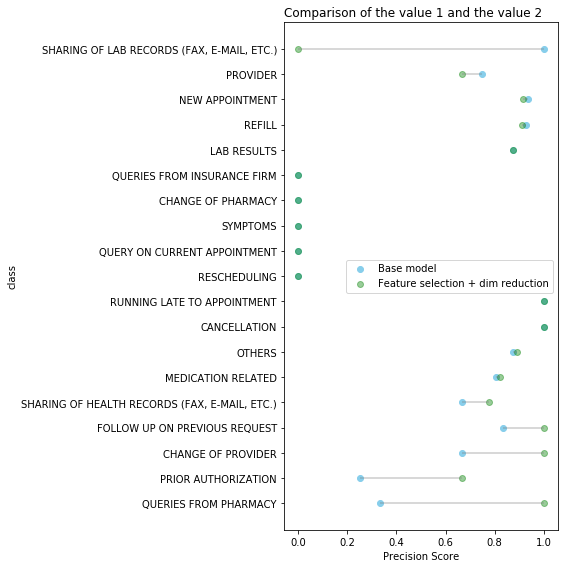

In [31]:
import matplotlib.pyplot as plt
#del my_range

ordered_df = df_class_compare.sort_values(by='difference')
my_range=range(1,len(ordered_df.index)+1)
 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.subplots(figsize=(8,8))
plt.hlines(y=my_range, xmin=ordered_df['precision_base'], xmax=ordered_df['precision_feature'], color='grey', alpha=0.4)
plt.scatter(ordered_df['precision_base'], my_range, color='skyblue', alpha=1, label='Base model')
plt.scatter(ordered_df['precision_feature'], my_range, color='green', alpha=0.4 , label='Feature selection + dim reduction')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['class'])
plt.title("Comparison of the value 1 and the value 2", loc='left')
plt.xlabel('Precision Score')
plt.ylabel('class')

# save the figure to folder
plt.tight_layout()
#plt.rcParams["figure.figsize"] = (20, 10)
#plt.savefig(r"compare_alldata_iterativetraining.png")

Here our feature selection + dimensionality reduction model was better at predicting 5 classes and worse at 2. It however did not help predicting the worst 5 classes ('change of pharmacy', 'symptoms', etc). If we look at the frequency of classes below, we can see that these classes have the lowest number of labels so perhaps they don't have very useful features or have high overlap with other classes. As for distributed error it looks like our new model did worse in this regard as we now have a single class that is significantly worse.

In [57]:
# view the frequency of classes
df_group.head(20)

,sub_categories,labels
15,REFILL,1612
7,MEDICATION RELATED,1449
8,NEW APPOINTMENT,1325
9,OTHERS,633
18,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)",562
6,LAB RESULTS,354
13,QUERIES FROM PHARMACY,331
11,PROVIDER,250
10,PRIOR AUTHORIZATION,210
16,RESCHEDULING,209
